<a href="https://colab.research.google.com/github/AISEN312/first-contributions/blob/main/FINALSOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

# Read the data
df = pd.read_csv('/content/extracted_50_data_points.csv')
print("Dataset shape:", df.shape)
print("\
First few rows of the dataset:")
print(df.head())

Dataset shape: (15, 6)
First few rows of the dataset:
                     Synthesis Method              Material Name  \
0                 Hydrothermal Method  NiO/SnO2 heterostructures   
1  Calcination and Nitrogen Annealing        NiO/SnO2 composites   
2       Ultrasonic Bath Precipitation              3NSR Catalyst   
3                 Hydrothermal Method        SnO2-x nanocrystals   
4                 Hydrothermal Method          SnO2 nanocrystals   

                          Types of Defect     Dopant Material  \
0                        Oxygen Vacancies                 NiO   
1                 Surface Hydroxyl Groups      Nickel Acetate   
2               Moderate Oxygen Vacancies                 NiO   
3                        Oxygen Vacancies                Sn2+   
4  Bridging and In-plane Oxygen Vacancies  Sn2+ (self-doping)   

   Band Gap Energy(eV)  Solar to Chemical Conversion Rate  
0                 1.88                               0.72  
1                 2.29    

In [14]:
# Prepare data for modeling
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['material_name_encoded'] = le.fit_transform(df['Material Name']) # Changed column name to 'Material Name'
df['synthesis_method_encoded'] = le.fit_transform(df['Synthesis Method']) # Changed column name to 'Synthesis Method'
df['defect_type_encoded'] = le.fit_transform(df['Types of Defect'])

# Prepare features and target
# Assuming the correct column name is 'Band Gap Energy' based on the error message
X = df[['material_name_encoded', 'synthesis_method_encoded', 'defect_type_encoded',
        'Band Gap Energy(eV)']]  # Changed 'band gap energy' to 'Band Gap Energy'
y = df['Solar to Chemical Conversion Rate']
lr_model = LinearRegression()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Dictionary of Models
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'LSTM': build_lstm_model((X.shape[1], 1))
}

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
from sklearn.metrics import r2_score

# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)
results = {}

# Evaluate Models
for name, model in models.items():
    train_scores = []
    test_scores = []
    rmse_scores = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_test_scaled = scaler.transform(X_test_fold)

        if name == 'LSTM':
            # Reshape for LSTM
            X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
            X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

            # Train and predict
            model.fit(X_train_scaled, y_train_fold, epochs=10, batch_size=32, verbose=0)

            # Predictions on train and test sets
            y_train_pred = model.predict(X_train_scaled).flatten()
            y_test_pred = model.predict(X_test_scaled).flatten()

            # Calculate Train and Test R² scores for LSTM
            train_score = r2_score(y_train_fold, y_train_pred)
            test_score = r2_score(y_test_fold, y_test_pred)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_test_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

        else:
            # Train and evaluate for non-LSTM
            model.fit(X_train_scaled, y_train_fold)
            train_score = model.score(X_train_scaled, y_train_fold)
            test_score = model.score(X_test_scaled, y_test_fold)
            y_pred = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))

            train_scores.append(train_score)
            test_scores.append(test_score)
            rmse_scores.append(rmse)

    # Store results for the current model
    results[name] = {
        'train_scores': train_scores,
        'test_scores': test_scores,
        'rmse_scores': rmse_scores
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [17]:
    print(f"\n{name} Results:")
    print(f"Average Train Score: {np.mean(train_scores):.4f}")
    print(f"Average Test Score: {np.mean(test_scores):.4f}")
    print(f"Average RMSE: {np.mean(rmse_scores):.4f}")


LSTM Results:
Average Train Score: -21.1544
Average Test Score: -154.2692
Average RMSE: 0.3949


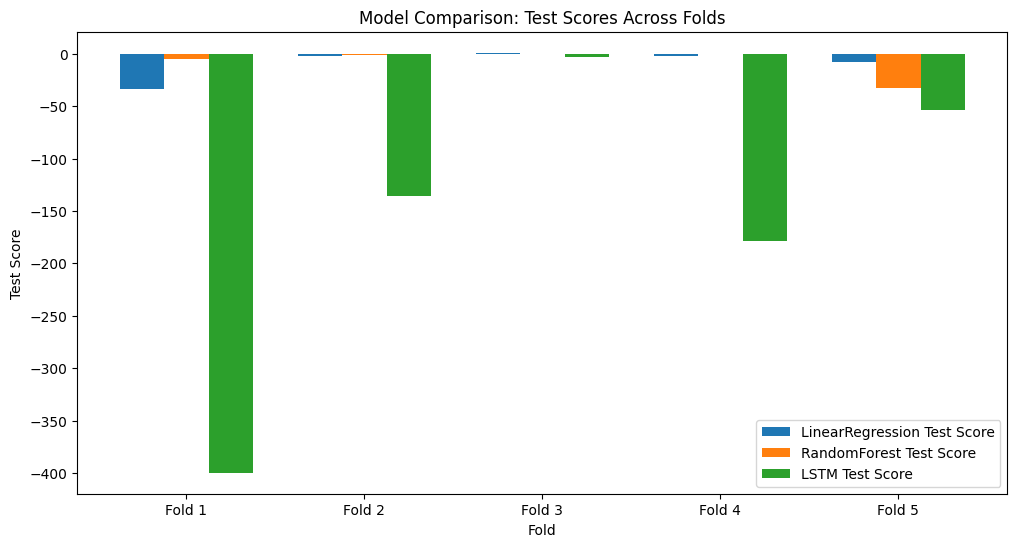

In [18]:
x = np.arange(5)
width = 0.25

# Test Score Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, [score if not np.isnan(score) else 0 for score in result['test_scores']],
            width, label=f'{name} Test Score')
plt.xlabel('Fold')
plt.ylabel('Test Score')
plt.title('Model Comparison: Test Scores Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()


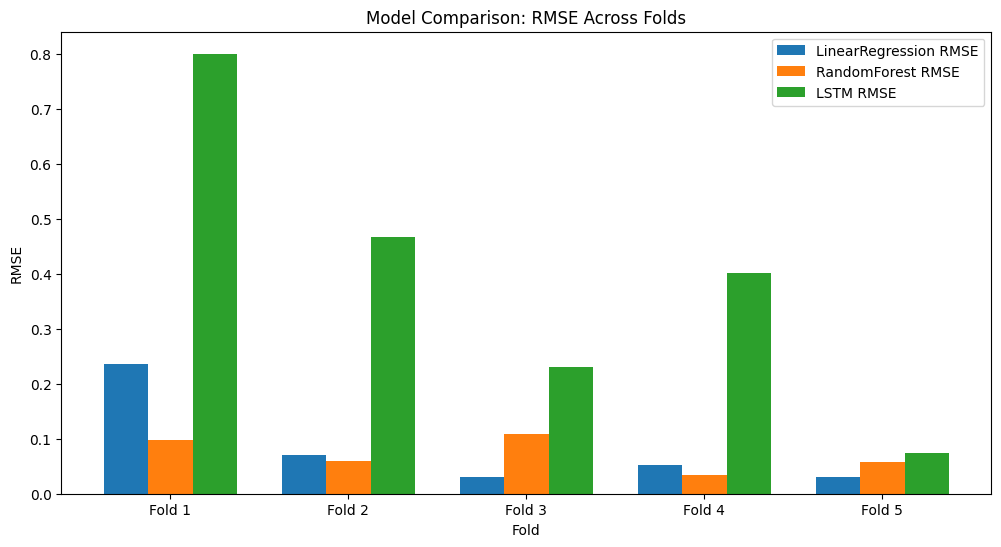

In [19]:
# RMSE Comparison Plot
plt.figure(figsize=(12, 6))
for i, (name, result) in enumerate(results.items()):
    plt.bar(x + i * width, result['rmse_scores'], width, label=f'{name} RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Model Comparison: RMSE Across Folds')
plt.legend()
plt.xticks(x + width, [f'Fold {i+1}' for i in range(5)])
plt.show()

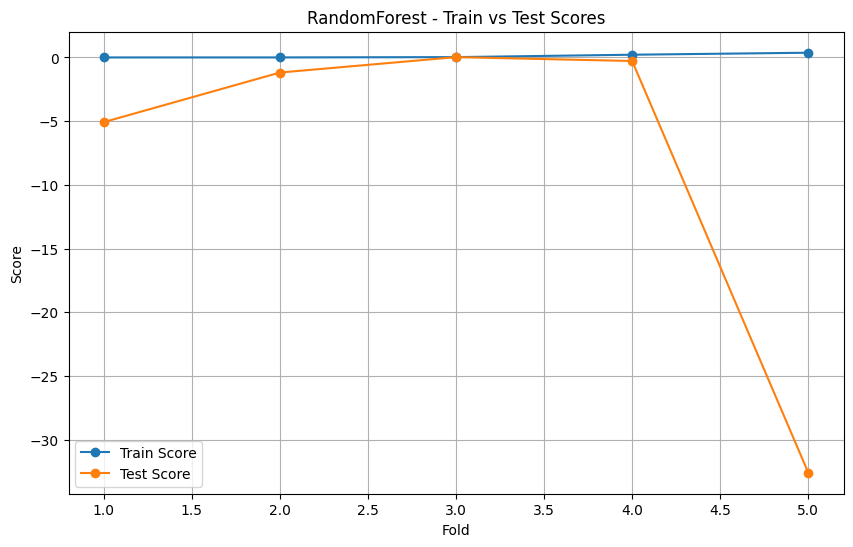

In [20]:
best_model_name = max(results.items(), key=lambda x: np.nanmean(x[1]['test_scores']))[0]
plt.figure(figsize=(10, 6))

if best_model_name != 'LSTM':
    plt.plot(range(1, 6), results[best_model_name]['train_scores'], 'o-', label='Train Score')
    plt.plot(range(1, 6), results[best_model_name]['test_scores'], 'o-', label='Test Score')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title(f'{best_model_name} - Train vs Test Scores')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("LSTM is the best model")

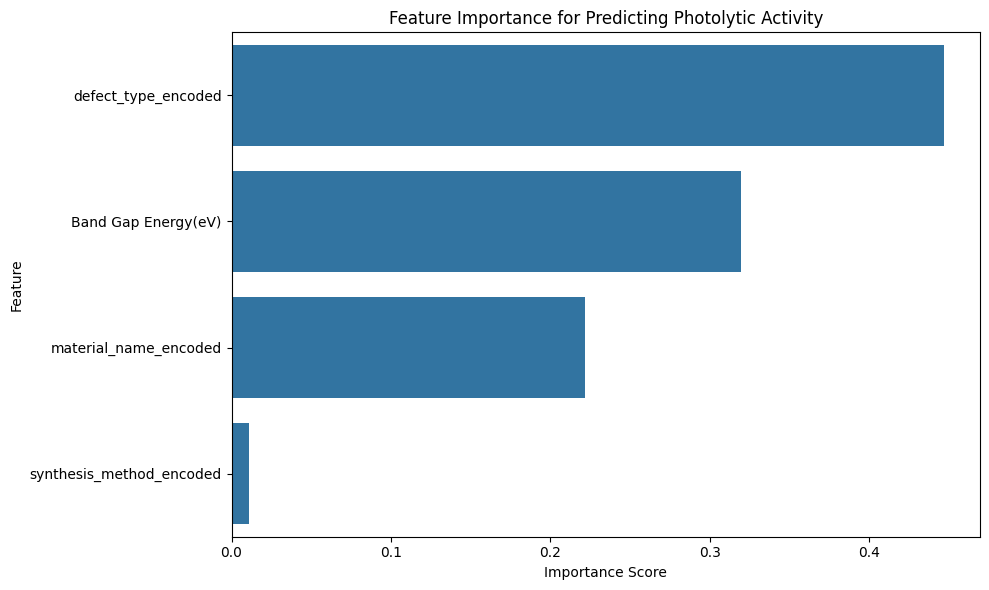

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'df' is your dataset
# Encode categorical variables
le = LabelEncoder()
df['material_name_encoded'] = le.fit_transform(df['Material Name'])
df['synthesis_method_encoded'] = le.fit_transform(df['Synthesis Method'])
df['defect_type_encoded'] = le.fit_transform(df['Types of Defect'])

# Select features and target variable
X = df[['material_name_encoded', 'synthesis_method_encoded', 'defect_type_encoded',
        'Band Gap Energy(eV)', ]]
y = df['Solar to Chemical Conversion Rate']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Calculate feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance for Predicting Photolytic Activity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


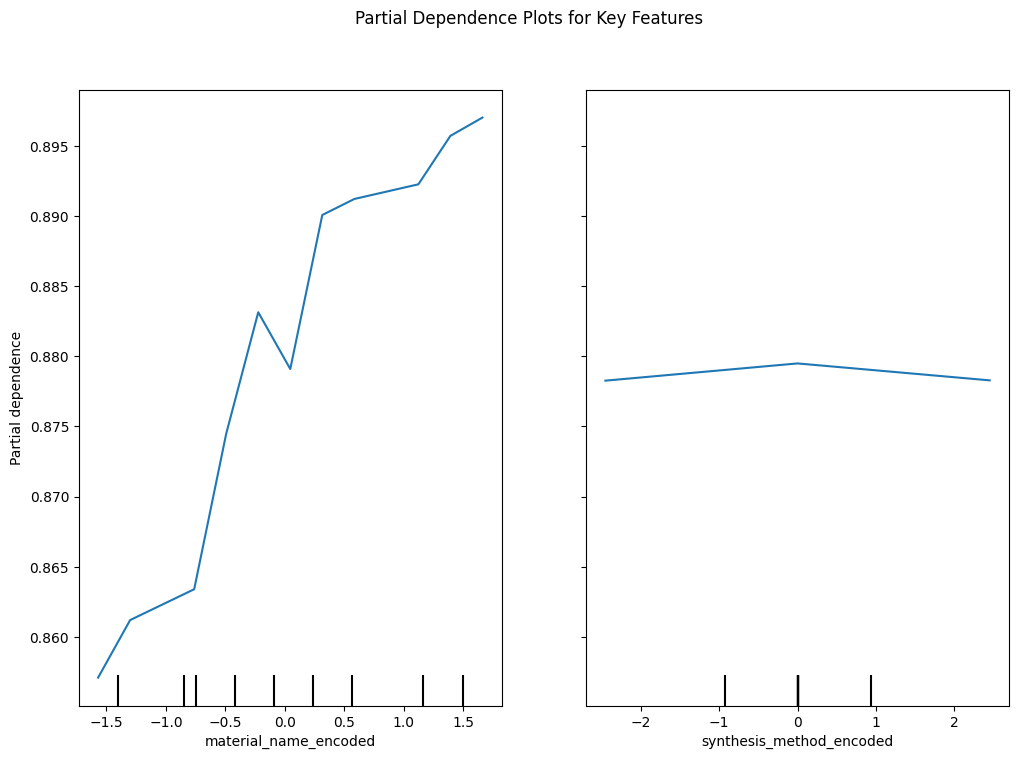

In [24]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Create a Partial Dependence Plot for the most important features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_train_scaled, [0, 1], ax=ax,
                                        feature_names=feature_names)
plt.suptitle('Partial Dependence Plots for Key Features')
plt.show()


In [26]:
import numpy as np

# Define the range of values for the most important features
material_range = np.linspace(X['material_name_encoded'].min(), X['material_name_encoded'].max(), 10)
synthesis_range = np.linspace(X['synthesis_method_encoded'].min(), X['synthesis_method_encoded'].max(), 10)
band_gap_range = np.linspace(X['Band Gap Energy(eV)'].min(), X['Band Gap Energy(eV)'].max(), 10)


# Generate all combinations of values for these features
synthetic_data = []
for material in material_range:
    for synthesis in synthesis_range:
        for band_gap in band_gap_range:

                synthetic_data.append([material, synthesis, 0, band_gap])  # 0 as a placeholder for 'defect type'

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=feature_names)

# Scale synthetic data using the previously fitted scaler
synthetic_scaled = scaler.transform(synthetic_df)

# Predict photolytic activity for synthetic data
synthetic_df['predicted_photolytic_activity'] = rf_model.predict(synthetic_scaled)

# Find the top 10 combinations with highest predicted photolytic activity
top_combinations = synthetic_df.sort_values(by='predicted_photolytic_activity', ascending=False).head(10)
print("Top 10 feature combinations for high photolytic activity:")
print(top_combinations)


Top 10 feature combinations for high photolytic activity:
     material_name_encoded  synthesis_method_encoded  defect_type_encoded  \
805              11.555556                  0.000000                    0   
965              13.000000                  1.333333                    0   
845              11.555556                  0.888889                    0   
844              11.555556                  0.888889                    0   
835              11.555556                  0.666667                    0   
814              11.555556                  0.222222                    0   
815              11.555556                  0.222222                    0   
825              11.555556                  0.444444                    0   
824              11.555556                  0.444444                    0   
915              13.000000                  0.222222                    0   

     Band Gap Energy(eV)  predicted_photolytic_activity  
805             2.646667            

In [27]:
# Assuming `le_material`, `le_synthesis`, and `le_defect` are the LabelEncoder objects used for encoding
# (initialize these encoders again if they are not already in your environment)

# Decode the categorical encoded columns back to their original labels
# Clip the values to be within the range of known labels
top_combinations['material name'] = le.inverse_transform(np.clip(top_combinations['material_name_encoded'].astype(int), 0, len(le.classes_) - 1))
top_combinations['synthesis method'] = le.inverse_transform(np.clip(top_combinations['synthesis_method_encoded'].astype(int), 0, len(le.classes_) - 1))
top_combinations['defect type'] = le.inverse_transform(np.clip(top_combinations['defect_type_encoded'].astype(int), 0, len(le.classes_) - 1))

# Drop the encoded columns for readability, keeping only the decoded labels
top_combinations_readable = top_combinations.drop(columns=['material_name_encoded', 'synthesis_method_encoded', 'defect_type_encoded'])

# Display the decoded top combinations
print("Top 10 feature combinations for high photolytic activity in readable format:")
print(top_combinations_readable)


Top 10 feature combinations for high photolytic activity in readable format:
     Band Gap Energy(eV)  predicted_photolytic_activity  \
805             2.646667                       0.857095   
965             2.646667                       0.857095   
845             2.646667                       0.857095   
844             2.493333                       0.857095   
835             2.646667                       0.857095   
814             2.493333                       0.857095   
815             2.646667                       0.857095   
825             2.646667                       0.857095   
824             2.493333                       0.857095   
915             2.646667                       0.857095   

               material name                        synthesis method  \
805  Surface Hydroxyl Groups  Bridging and In-plane Oxygen Vacancies   
965  Surface Hydroxyl Groups      Dominant In-plane Oxygen Vacancies   
845  Surface Hydroxyl Groups  Bridging and In-plane Oxyge